In [1]:
%load_ext autoreload
%autoreload 2

In [32]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split



import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

from torchvision import transforms as T
import torchvision



from PIL import Image
import cv2
import albumentations as A

import time
import os
from tqdm.notebook import tqdm

from pathlib import Path

In [59]:
def load_image_mask(impath, mspath, alpha_val=0.6, figsize_val=(10,10)):
    img = Image.open(str(impath))
    mask = Image.open(str(mspath))
    print('Image Size', np.asarray(img).shape)
    print('Mask Size', np.asarray(mask).shape)

    plt.figure(figsize=figsize_val)
    plt.imshow(img)
    plt.imshow(mask, alpha=alpha_val)
    plt.title('Picture with Mask Appplied')
    plt.show()
    

In [212]:
class DroneSegmentation(Dataset):
    def __init__(self, root, val_size=0.1, mode='train', image_transform=None, mask_transform=None):
        self.root = root
        self.val_size = val_size
        self.mode = mode
        self.image_transform = image_transform
        self.mask_transform = mask_transform
        
        self._load_files()
        self._create_dataframe()
        self._create_classes_dataframe()
        self._split_dataframe()
    
    def _load_files(self):
        IMAGE_PATH = Path(ROOT_PATH).joinpath('images')
        MASK_PATH = Path(ROOT_PATH).joinpath('gt/semantic/label_images')
        CLASS_DICT = Path(ROOT_PATH).joinpath('gt/semantic/class_dict.csv')
        
        self.image_files = sorted(list(IMAGE_PATH.glob('*.jpg')))
        self.mask_files = sorted(list(MASK_PATH.glob('*.png')))
        self.class_df = pd.read_csv(str(CLASS_DICT))
        
        
    def _create_dataframe(self):
        names, imgs_path, msks_path = [],[],[]
        for idx in range(len(image_files)):
            name = self.image_files[idx].stem
            img_path = str(self.image_files[idx])
            msk_path = str(self.mask_files[idx])

            names.append(name)
            imgs_path.append(img_path)
            msks_path.append(msk_path)

        data_dict = {
            'id': names,
            'image_path': imgs_path,
            'mask_path': msks_path
        }
        self.dataframe = pd.DataFrame(data_dict)
        
        
    def _create_classes_dataframe(self):
        names, colors = [], []
        for idx in range(len(class_df)):
            name = self.class_df['name'].iloc[idx]
            r = self.class_df[' r'].iloc[idx] 
            g = self.class_df[' g'].iloc[idx] 
            b = self.class_df[' b'].iloc[idx] 
            color = (r,g,b)
            names.append(name)
            colors.append(color)

        classes_dict = {
            'name': names,
            'color': colors,
        }

        self.classes_dataframe = pd.DataFrame(classes_dict)
        
    def _load_image(self, path, to_np=False):
        img = Image.open(path)
        if to_np:
            img = np.array(img)
        return img
    
    def _convert_to_classes_masks(self, mask):
        masks = []
        for color in colors:
            canvas = np.zeros((h,w))
            label_img = mask == color
            label_img = label_img.astype(np.int64)
            label_img = ((label_img[:,:,0] * 255) + (label_img[:,:,1] * 255) + (label_img[:,:,2] * 255))/3
            masks.append(label_img)
        masks = np.dstack(masks)
        return masks
        
    def _split_dataframe(self):
        self.trainset, self.validset = train_test_split(self.dataframe, test_size=self.val_size, random_state=19)
        if self.mode == 'train':
            self.files = self.trainset
        else:
            self.files = self.validset
    
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        impath = self.files['image_path'].iloc[idx]
        mspath = self.files['mask_path'].iloc[idx]
        
        orig_img = self._load_image(impath)
        mask_img = self._load_image(mspath, to_np=True)
        mask_img = self._convert_to_classes_masks(mask_img)
        
        return orig_img, mask_img
    
        

In [213]:
ROOT_PATH = '/data/semantic_drone/training_set'
trainset = DroneSegmentation(root=ROOT_PATH,  mode='train', val_size=0.4)
validset = DroneSegmentation(root=ROOT_PATH,  mode='valid', val_size=0.4)

# trainset.files

# impath = X_trainval['image_path'].iloc[idx]
# mspath = X_trainval['mask_path'].iloc[idx]
# load_image_mask(impath, mspath)

In [214]:
%%time
orig, masks = trainset[0]

CPU times: user 11.3 s, sys: 5.19 s, total: 16.5 s
Wall time: 16.5 s


In [215]:
# idx = 10
# impath = trainset[idx]['image_path']
# mspath = trainset[idx]['mask_path']
# im_imfile = Image.open(impath)
# im_imfile = np.array(im_imfile)
# ms_imfile = Image.open(mspath)
# mask = np.array(ms_imfile)

In [ ]:
import tifffile as tiff
tiff.imsave('test.tiff', masks, compress='lzma')

In [209]:
%%time


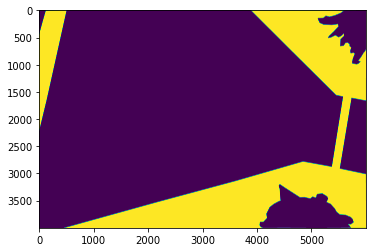

In [201]:
# plt.imshow(masks[:,:,4])
#     print(names[15])
#     plt.imshow(im_imfile)
#     plt.imshow(msfile_label, alpha=0.9);
#     plt.show()

In [153]:
names = trainset.classes_dataframe['name']
colors = trainset.classes_dataframe['color']

In [187]:
colors, names

(0           (0, 0, 0)
 1      (128, 64, 128)
 2        (130, 76, 0)
 3         (0, 102, 0)
 4      (112, 103, 87)
 5       (28, 42, 168)
 6        (48, 41, 30)
 7         (0, 50, 89)
 8      (107, 142, 35)
 9        (70, 70, 70)
 10    (102, 102, 156)
 11     (254, 228, 12)
 12     (254, 148, 12)
 13    (190, 153, 153)
 14    (153, 153, 153)
 15      (255, 22, 96)
 16       (102, 51, 0)
 17      (9, 143, 150)
 18      (119, 11, 32)
 19        (51, 51, 0)
 20    (190, 250, 190)
 21    (112, 150, 146)
 22      (2, 135, 115)
 23        (255, 0, 0)
 Name: color, dtype: object,
 0       unlabeled
 1      paved-area
 2            dirt
 3           grass
 4          gravel
 5           water
 6           rocks
 7            pool
 8      vegetation
 9            roof
 10           wall
 11         window
 12           door
 13          fence
 14     fence-pole
 15         person
 16            dog
 17            car
 18        bicycle
 19           tree
 20      bald-tree
 21      ar-marker
 